# Importing Libraries

In [4]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import os
from torchvision import transforms
import torchvision.transforms as standard_transforms
from torch.utils.data import DataLoader
from darrennet.main import MaskToTensor
from darrennet.voc import VOC
from darrennet.dataset import load_dataset
from darrennet.train import export_model
from darrennet.basic_fcn import FCN
from torchvision.transforms import v2
from PIL import Image

import warnings
warnings.filterwarnings('ignore')

ImportError: cannot import name 'export_model' from partially initialized module 'darrennet.train' (most likely due to a circular import) (c:\Users\Darren Yu\OneDrive\Documents\GitHub\cse151b251b-wi24-pa2-darrennet\darrennet\train.py)

# Mapping Class to Color

In [ ]:
# Class type/name by index
noToClass = {0:"background", 1:"aeroplane", 2:"bicycle", 3:"bird", 4:"boat", 5:"bottle", 6:"bus", 7:"car", 8:"cat", 9:"chair", 10:"cow", 11:"dining table",
             12:"dog", 13:"horse", 14:"motorbike", 15:"person", 16:"potted plant", 17:"sheep", 18:"sofa", 19:"train", 20:"tv/monitor"}

# RGB values of each class starting from idx 0 to idx 20
palette = [0, 0, 0, 128, 0, 0, 0, 128, 0, 128, 128, 0, 0, 0, 128, 128, 0, 128, 0, 128, 128,
           128, 128, 128, 64, 0, 0, 192, 0, 0, 64, 128, 0, 192, 128, 0, 64, 0, 128, 192, 0, 128,
           64, 128, 128, 192, 128, 128, 0, 64, 0, 128, 64, 0, 0, 192, 0, 128, 192, 0, 0, 64, 128]

# Palette mapped to a dictionary with class index as keys
palette = {i // 3: (palette[i], palette[i + 1], palette[i + 2]) for i in range(0, 3*21, 3)}
print(f"RGB dictionary: {palette}")

RGB dictionary: {0: (0, 0, 0), 1: (128, 0, 0), 2: (0, 128, 0), 3: (128, 128, 0), 4: (0, 0, 128), 5: (128, 0, 128), 6: (0, 128, 128), 7: (128, 128, 128), 8: (64, 0, 0), 9: (192, 0, 0), 10: (64, 128, 0), 11: (192, 128, 0), 12: (64, 0, 128), 13: (192, 0, 128), 14: (64, 128, 128), 15: (192, 128, 128), 16: (0, 64, 0), 17: (128, 64, 0), 18: (0, 192, 0), 19: (128, 192, 0), 20: (0, 64, 128)}


# Transformations to be done on images

In [ ]:
# Our transformations
mean_std = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
input_transform = v2.Compose(
    [
        v2.ToImage(),
        v2.Resize((224, 224)),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(*mean_std),
    ]
)
mask_transform = v2.Compose(
    [
        v2.Lambda(lambda x: x.resize((224, 224))),
        v2.ToImage(),
    ]
)

# Getting random test image and mask

In [ ]:
# Convert each set into a dataloader
train, val, test = load_dataset(None, input_transform, mask_transform, size=1)
first_batch = iter(test)

# Plotting Functions

In [ ]:
# Function to formate the img or mask to the appropriate shape before plotting
def makeImagesPlotReady(image):
    batch, depth, height, width = image.shape
    reshape_img = image[0]

    # Get the rgb channels and reshape the image to height x width x depth
    r, g, b = reshape_img
    reshape_img = np.array([[[r[i][j], g[i][j], b[i][j]] for j in range(width)] for i in range(height)])
    return reshape_img

def convertMaskToRGB(msk_1d):
    b, d, h, w = msk_1d.shape
    mask_rgb = np.zeros((1, 3, h, w), dtype=np.uint8)

    # Loop through every pixel of the mask and set the corresponding RGB values
    for i in range(h):
        for j in range(w):
            mask_rgb[0][0][i][j], mask_rgb[0][1][i][j], mask_rgb[0][2][i][j] = palette[int(msk_1d[0][0][i][j])]
    return mask_rgb

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


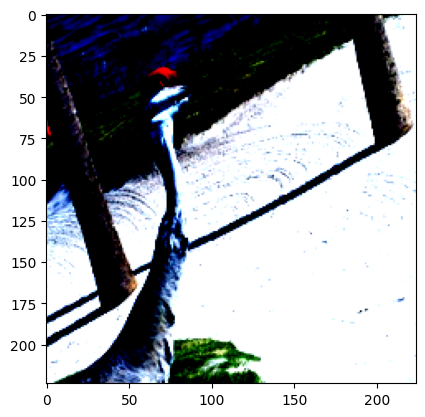

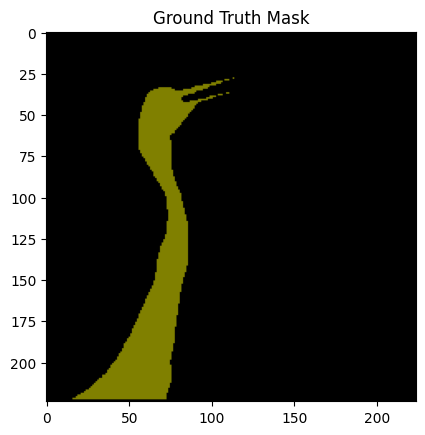

In [ ]:
# Reload the cell to produce the next image
img, msk = next(first_batch)

# Example use of the plot ready function
plt.imshow(makeImagesPlotReady(img))
plt.show()

# Check your makeImagesPlotReady implementation by printing the msk variable
mask_rgb = convertMaskToRGB(msk)
plt.imshow(makeImagesPlotReady(mask_rgb))
plt.title("Ground Truth Mask")
plt.show()

# Running Inference on all trained models

In [ ]:
def returnToString(arr):
    string = ""
    for i in arr:
        string += noToClass[i]
        string += ", "
    return string[:-2]

def compare_models(model_paths, model_names):
    # Get the next image in test
    img, msk = next(first_batch)

    # Create models here
    models = [torch.load(os.path.join("models/" + m + ".pkl")) for m in model_paths]
    numberOfModels = len(models) + 1
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    true_classes = [noToClass[i] for i in torch.unique(msk).numpy()]
    print("GROUND TRUTH CLASSES:", true_classes,"\n")

    output_images = [convertMaskToRGB(msk)]
    for i in range(numberOfModels - 1):
        output_image = export_model(models[i], device, img)

        output_image = output_image.to("cpu").detach() # Remove torch components and push to cpu
        output_image = torch.argmax(output_image, dim=1) # converting softmax to OHE
        print(f"Model \"{model_names[i]}\" Predicted Classes:", returnToString(torch.unique(output_image).numpy()))

        output_image = output_image[None,:,:,:]
        mask_rgb = convertMaskToRGB(output_image)
        output_images.append(mask_rgb)
    
    model_names.insert(0, "Ground Truth")
    # Show masks only
    print("Prediction Masks")
    fig, axs = plt.subplots(2, 4, figsize=(12, 6))
    axs = axs.flatten()
    for c in range(numberOfModels):
        axs[c].imshow(makeImagesPlotReady(output_images[c]))
        axs[c].set_title(model_names[c])
        axs[c].axis('off')
    plt.show()
    
    # Show mask with image
    print("Prediction Masks with Image")
    fig, axs = plt.subplots(2, 4, figsize=(12, 6))
    axs = axs.flatten()
    for c in range(numberOfModels):
        axs[c].imshow(makeImagesPlotReady(img))
        axs[c].imshow(makeImagesPlotReady(output_images[c]), alpha = 0.6)
        axs[c].set_title(model_names[c])
        axs[c].axis('off')
    plt.show()

GROUND TRUTH CLASSES: ['background', 'sheep'] 

Model "UNet + Augment_2" Predicted Classes: background, aeroplane, bicycle, bird, boat, bottle, bus, car, cat, chair, cow, dining table, dog, horse, motorbike, person, potted plant, sheep, sofa, train, tv/monitor
Model "SMP" Predicted Classes: background, cat, chair, person
Model "UNet-ResNet" Predicted Classes: background
Model "UNet" Predicted Classes: background, bicycle, bird, bus, car, cat, chair, dining table, dog, horse, motorbike, person, sofa, train, tv/monitor
Prediction Masks


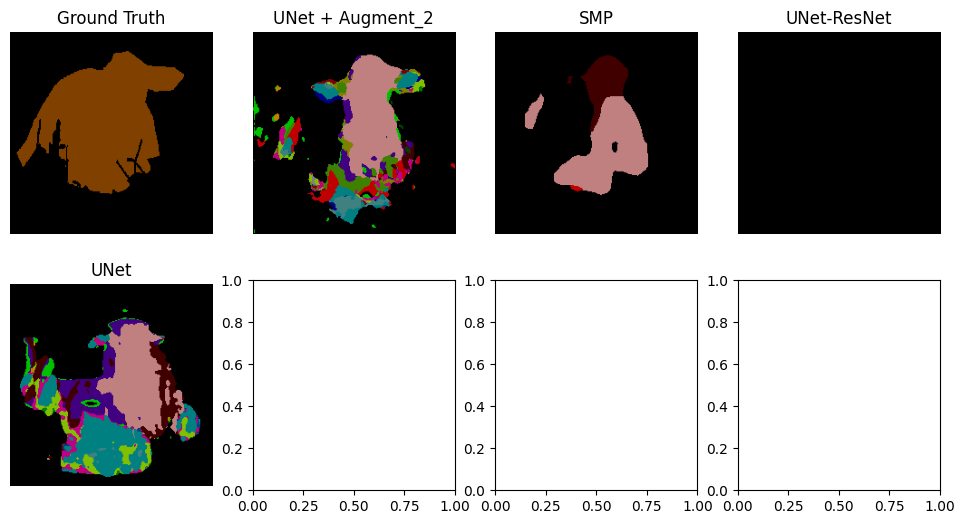

Prediction Masks with Image


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


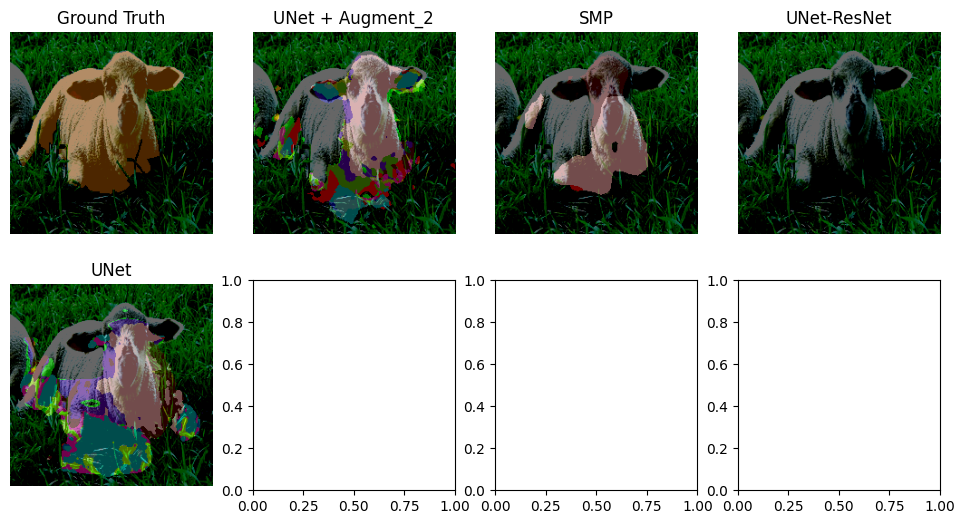

In [ ]:
# Rerun to compare with another image
model_locations = ["augment_2", "smp", "unet_resnet", "unet"]
model_names = ["UNet + Augment_2", "SMP", "UNet-ResNet", "UNet"]
compare_models(model_locations, model_names)